# Chest X-Ray Pneumonia detection with neural network

The following notebook implements a neural network from scratch.

## 1. Setup

First of all we need to import a few modules and declare a few global variables.

Global variables:
- **NORMAL_OUTPUT_VALUE = 0**: prediction = no pneunomia
- **PNEUMONIA_OUTPUT_VALUE = 1**: prediction = pneunomia
- **SEED**: start value for "pseudo random" numbers

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
from enum import Enum
from mlxtend.plotting import plot_confusion_matrix
from sklearn import metrics
from sklearn.metrics import confusion_matrix

NORMAL_OUTPUT_VALUE = 0
PNEUMONIA_OUTPUT_VALUE = 1
SEED = 2
random.seed(SEED)

## 2. Useful Functions

The following functions are useful "standard" functions to implement a neural network.
- **sigmoid**: s-like function between 0 and 1
- **relu**: 0 for x < 0, x for x ≥ 0

In [2]:
def sigmoid(x):
    """
    Compute the sigmoid of x

    Arguments:
    x - A scalar or numpy array of any size.

    Return:
    s - sigmoid(x)
    """
    s = 1/(1+np.exp(-x))
    return s

In [3]:
def relu(x):
    """
    Compute the relu of x

    Arguments:
    x - A scalar or numpy array of any size.

    Return:
    s - relu(x)
    """
    s = np.maximum(0,x)
    
    return s


## 3. Load Data Set

The Chest X-ray data we are using from https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images divides the data into train and test files:
- 11% test files
- 89% training files

The original image size is very big, so we down scaled them to get a better performance. Therefore we used a python script 'PythonImageScaler.py'.

You can switch between a HIGH and a LOW resolution:
- HIGH: 224 x 224
- LOW: 56 x 56

In [4]:
# Enum to choose resolution of images
class Resolution(Enum):
    HIGH = 1
    LOW = 2

In [5]:
def load_dataset(resolution):
    """
    Collect all the paths of the scaled images and load them into the program
    as numpy arrays.

    Hint: The original images from https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images
    have been downscaled with the sperate python script 'PythonImageScaler.py'

    Returns:
    train_X - All training images
    train_Y - All true outputs of all training images
    test_X - All test images
    test_Y - All true outputs of all test images

    """

    # Define the root directories of the train and test sets.
    global WIDTH
    if(resolution == Resolution.HIGH):
        WIDTH = 224
        scaled_train_dir = "scaled_chest_xray/train/"
        scaled_test_dir = "scaled_chest_xray/test/"
    else:
        WIDTH = 56
        scaled_train_dir = "scaled2_chest_xray/train/"
        scaled_test_dir = "scaled2_chest_xray/test/"
    

    # Define the root directories of the normal and pneumonia 
    # test and trainsets.
    scaled_train_pneu = os.listdir(os.path.join(scaled_train_dir, 'PNEUMONIA'))
    scaled_train_normal = os.listdir(os.path.join(scaled_train_dir, 'NORMAL'))
    scaled_test_pneu = os.listdir(os.path.join(scaled_test_dir, 'PNEUMONIA'))
    scaled_test_normal = os.listdir(os.path.join(scaled_test_dir, 'NORMAL'))

    # Collect all paths from the training images and test images
    # and combine these with the true output value (either 
    # NORMAL_OUTPUT_VALUE or PNEUMONIA_OUTPUT_VALUE)
    train_set_image_paths = [('PNEUMONIA/' + name, PNEUMONIA_OUTPUT_VALUE) for name in scaled_train_pneu] + [('NORMAL/' + name, NORMAL_OUTPUT_VALUE) for name in scaled_train_normal]
    test_set_image_paths = [('PNEUMONIA/' + name, PNEUMONIA_OUTPUT_VALUE) for name in scaled_test_pneu] + [('NORMAL/' + name, NORMAL_OUTPUT_VALUE) for name in scaled_test_normal]

    # Shuffle the lists
    random.shuffle(train_set_image_paths) 
    random.shuffle(test_set_image_paths) 

    # Open all image paths and read all the grayscale data from every
    # grayscale image. 
    # ".convert('L')" makes sure that the image is
    # definitely a grayscale, since some images have a few rgb
    # values within the image, which caused problems.
    test_X_list = [list(Image.open(scaled_test_dir + image_path).getdata().convert('L')) for image_path, i in test_set_image_paths]
    train_X_list = [list(Image.open(scaled_train_dir + image_path).getdata().convert('L')) for image_path, i in train_set_image_paths]

    # Downscale the grayscale value for a pixel from [0;255] to [0;1]
    test_X_list = [[float(value)/255 for value in image_data] for image_data in test_X_list]
    train_X_list = [[float(value)/255 for value in image_data] for image_data in train_X_list]

    # Convert both  the test and train lists to actual numpy arrays
    train_X = np.array(train_X_list, dtype=float).T
    test_X = np.array(test_X_list, dtype=float).T
    train_Y = np.array([[float(i) for image_path, i in train_set_image_paths]], dtype=float)
    test_Y = np.array([[float(i) for image_path, i in test_set_image_paths]], dtype=float)

    return (train_X, train_Y, test_X, test_Y)

train_X.shape:(3136, 5232)
train_Y.shape:(1, 5232)
test_X.shape:(3136, 624)
test_Y.shape:(1, 624)


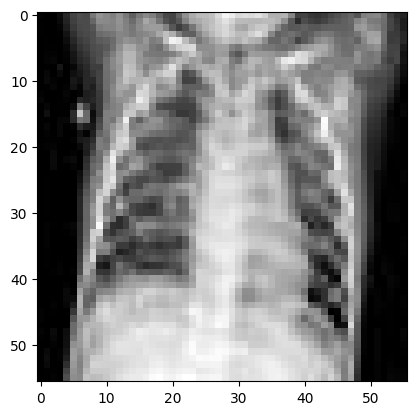

In [6]:
train_X, train_Y, test_X, test_Y = load_dataset(Resolution.LOW)
print("train_X.shape:{}".format(train_X.shape))
print("train_Y.shape:{}".format(train_Y.shape))
print("test_X.shape:{}".format(test_X.shape))
print("test_Y.shape:{}".format(test_Y.shape))

index = 10
# show an example image
plt.imshow(test_X.T[index].reshape(WIDTH, WIDTH), cmap='gray')

## 4. Initialize Parameters

This function initializes all parameters in the weight matrix "W" and bias matrix "b". We wanted our neural network to be as flexible as possible. To do so we pass "layer_dims" to the initialize_parameters.

layer_dims is an array containing the dimensions of each layer in the network. So it is possible to choose the amount of hidden layers and the amount of neurons for each hidden layer.

example:

 layer_dims = \[**train_X.shape\[0\]**, **200**, **20**, **2**, **train_Y.shape\[0\]**\] 

- **train_X.shape[0]** : neurons of the input layer
- **200** : first hidden layer with 200 neurons
- **20** : second hidden layer with 20 neurons
- **2** : third hidden layer with 2 neurons
- **train_Y.shape[0]** : neurons of the output layer

In [7]:
def initialize_parameters(layer_dims):
    """
    Initialize all parameters of the neural network based on each layer dimension given
    in layer_dims. 

    Arguments:
    layer_dims - python array (list) containing the dimensions of each layer in the network
    
    Returns:
    parameters - python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
        W1 - weight matrix of shape (layer_dims[l], layer_dims[l-1])
        b1 - bias vector of shape (layer_dims[l], 1)
        Wl - weight matrix of shape (layer_dims[l-1], layer_dims[l])
        bl - bias vector of shape (1, layer_dims[l])
    """
    
    np.random.seed(SEED)
    parameters = {}
    # Number of layers in the network
    number_of_layers = len(layer_dims)
    
    # Generate the all weight and biases matrices for the
    # Neural Network based of the values and number of values
    # in layer_dims
    print("Generating a network with the following shapes of the weights and biases:")
    for layer in range(1, number_of_layers):
        parameters['W' + str(layer)] = np.random.randn(layer_dims[layer], layer_dims[layer-1])*0.01
        parameters['b'  + str(layer)] = np.zeros((layer_dims[layer], 1))
        
        # Print all shapes from all parameters
        print("{}:{}".format('W' + str(layer), parameters['W' + str(layer)].shape))
        print("{}:{}".format('b' + str(layer), parameters['b' + str(layer)].shape))

        assert(parameters['W' + str(layer)].shape == (layer_dims[layer], layer_dims[layer-1]))
        assert(parameters['b'  + str(layer)].shape == (layer_dims[layer], 1))
        
    return parameters

## 5. Forward Propagation

To stay flexible in treating overfitting, we decided to implement regularization. In class we learned about two regularization methods: L2 regularization and dropout. L2 regularization has an impact on the cost function and the backward propagation. Dropout impacts forward and backward propagation. To be able to switch between non regularization, L2 and dropout we need different implementations of the same functions.

So we need two functions for forward propagation, one for non regularization and L2 regularization and one for dropout.

In [8]:
def forward_propagation(X, parameters):
    """
    Propagate input features through the neural network.
    
    Argument:
    X - Input features
    parameters - python dictionary containing all parameters (output of initialization function)
    
    Returns:
    A2 - The sigmoid output of the last activation layer
    cache - a dictionary containing all values of "A1", "Z1, ... "AL", "ZL"
    """
    
    cache = {}
    # Number of layers in the network
    number_of_layers = int(len(parameters)/2)-1
    last_A = X
    for layer in range(1, number_of_layers+1):
        # Calculate Z and A of current layer
        Z = np.matmul(parameters['W'+ str(layer)], last_A) + parameters['b' + str(layer)]
        A = relu(Z)
        # Update cache with Z and A from current layer
        cache.update({'Z' + str(layer): Z})
        cache.update({'A' + str(layer): A})
        # Temporaily save A to use in the next iteration
        last_A = A 

    Z = np.matmul(parameters['W' + str(number_of_layers+1)], last_A) + parameters['b' + str(number_of_layers+1)]
    A = sigmoid(Z)
    cache.update({'Z' + str(number_of_layers+1): Z})
    cache.update({'A' + str(number_of_layers+1): A})
    
    assert(A.shape == (1, X.shape[1]))
    
    return A, cache

In [9]:
def forward_propagation_with_dropout(X, parameters, keep_probability = 0.5):
    """
    Propagate input features through the neural network.
    
    Argument:
    X - input features
    parameters - python dictionary containing all parameters (output of initialization function)
    
    Returns:
    A - the sigmoid output of the last activation layer
    cache - a dictionary containing all values of "A1", "Z1", "D1", ... "AL", "ZL", "DL"
    """
    
    cache = {}
    # Number of layers in the network
    number_of_layers = int(len(parameters)/2)-1
    last_A = X
    for layer in range(1, number_of_layers+1):
        # Calculate Z and A of current layer
        Z = np.matmul(parameters['W'+ str(layer)], last_A) + parameters['b' + str(layer)]
        A = relu(Z)
        # Droput
        D = np.random.rand(A.shape[0], A.shape[1])
        D = (D < keep_probability).astype(int)
        A = A * D
        A = A / keep_probability
        # Update cache with D, Z and A from current layer
        cache.update({'D' + str(layer): D})
        cache.update({'Z' + str(layer): Z})
        cache.update({'A' + str(layer): A})
        # Temporaily save A to use in the next iteration
        last_A = A 

    Z = np.matmul(parameters['W' + str(number_of_layers+1)], last_A) + parameters['b' + str(number_of_layers+1)]
    A = sigmoid(Z)
    cache.update({'Z' + str(number_of_layers+1): Z})
    cache.update({'A' + str(number_of_layers+1): A})
    
    assert(A.shape == (1, X.shape[1]))
    
    return A, cache

## 6. Cost function

The following two methods calculate the cost function. The first function calculates the cross-entropy cost, the second one calculates the cost function for the L2 regularization. Therefore you need to add the sum of the weights to the cross-entropy costs. 

In [10]:
def compute_cost(A, Y):
    """
    Computes the cross-entropy cost given in equation
    
    Arguments:
    A -- the sigmoid output of the last activation, of shape (1, number of examples)
    Y -- labels vector of shape (1, number of examples)
    
    Returns:
    cost -- cross-entropy cost given equation
    
    """
    m = Y.shape[1] # number of example

    # Compute the cross-entropy cost
    epsilon = 1e-7
    cost = -(1/m)* float(np.dot(Y, np.log(A.T + epsilon)) + np.dot(1-Y,np.log(1-A.T + epsilon)))
    
    assert(isinstance(cost, float))

    return cost

In [11]:
def compute_cost_with_regularization(A, Y, parameters, lambd):
    """
    Implements the cost function with L2 regularization.
    
    Arguments:
    A -- post-activation, output of forward propagation, of shape (output size, number of examples)
    Y -- labels vector, of shape (output size, number of examples)
    parameters -- python dictionary containing parameters of the model
    
    Returns:
    cost - value of the regularized loss function
    """
    m = Y.shape[1]
    
    # This gives you the cross-entropy part of the cost
    cross_entropy_cost = compute_cost(A, Y)
    number_of_layers = int(len(parameters)/2)-1

    # calculate sum of weights W
    sum_of_all_weights = 0.0
    for layer in range(1, number_of_layers+1):
        sum_of_all_weights = sum_of_all_weights + np.sum(np.square(parameters['W' + str(layer)]))

    L2_regularization_cost = lambd/(2*m) * sum_of_all_weights
    cost = cross_entropy_cost + L2_regularization_cost


    return cost

## 7. Backward Propagation
In case of backward propagation we need three different implementations. One for no regularization, one for L2 regularization and one for dropout. You find the three functions below.

In [12]:
def backward_propagation(parameters, cache, X, Y):
    """
    Implements the backward propagation without regularization.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing all values of "A1", "Z1", "D1", ... "AL", "ZL", "DL"
    X -- input data
    Y -- labels vector
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    grads = {}
    number_of_layers = int(len(parameters)/2)-1

    # calculate dZ, dW, db of last layer
    dZ = cache['A' + str(number_of_layers+1)] - Y
    dW = (1/m)*np.matmul(dZ,cache['A' + str(number_of_layers)].T)
    db = (1/m)*np.sum(dZ, axis=1, keepdims = True)
    # update gradients in dictionary
    grads.update({'dW' + str(number_of_layers+1): dW})
    grads.update({'db' + str(number_of_layers+1): db})

    last_dZ = dZ
    # calculate dZ, dW, db of hidden layers
    for layer in range(number_of_layers, 1, -1):
        dZ = np.matmul(parameters['W' + str(layer+1)].T,last_dZ)* np.heaviside(cache['A' + str(layer)], 1)
        dW = (1/m)*np.matmul(dZ,cache['A' + str(layer-1)].T)
        db = (1/m)*np.sum(dZ, axis=1, keepdims = True)
        # update gradients in dictionary
        grads.update({'dW' + str(layer): dW})
        grads.update({'db' + str(layer): db})
        last_dZ = dZ 
    
    # calculate dZ1, dW1, db1
    dZ1 = np.matmul(parameters['W2'].T,last_dZ)* np.heaviside(cache['A1'], 1)
    dW1 = (1/m)*np.matmul(dZ1,X.T)
    db1 = (1/m)*np.sum(dZ1, axis=1, keepdims = True)
    # update gradients in dictionary
    grads.update({'dW1': dW1})
    grads.update({'db1': db1})
    
    return grads

In [13]:
def backward_propagation_with_regularization(parameters, cache, X, Y, lambd):
    """
    Implements the backward propagation with L2 regularization.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing all values of "A1", "Z1", "D1", ... "AL", "ZL", "DL"
    X -- input dataset
    Y -- labels vector
    lambd -- regularization hyperparameter, scalar
    
    Returns:
    grads -- dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    
    m = X.shape[1]
    grads = {}
    number_of_layers = int(len(parameters)/2)-1

    # calculate dZ, dW, db of last layer with regard of L2 regularization
    dZ = cache['A' + str(number_of_layers+1)] - Y
    dW = (1/m)*(np.matmul(dZ,cache['A' + str(number_of_layers)].T)+lambd*parameters['W' + str(number_of_layers+1)])
    db = (1/m)*np.sum(dZ, axis=1, keepdims = True)
    # update gradients in dictionary
    grads.update({'dW' + str(number_of_layers+1): dW})
    grads.update({'db' + str(number_of_layers+1): db})

    last_dZ = dZ
    # calculate dZ, dW, db of the hidden layers with regard of L2 regularization
    for layer in range(number_of_layers, 1, -1):
        dZ = np.matmul(parameters['W' + str(layer+1)].T,last_dZ)* np.heaviside(cache['A' + str(layer)], 1)
        dW = (1/m)*(np.matmul(dZ,cache['A' + str(layer-1)].T)+lambd*parameters['W' + str(layer)])
        db = (1/m)*np.sum(dZ, axis=1, keepdims = True)
        # update gradients in dictionary
        grads.update({'dW' + str(layer): dW})
        grads.update({'db' + str(layer): db})
        last_dZ = dZ 
    
    # calculate dZ1, dW1, db1 of first layer with regard of L2 regularization
    dZ1 = np.matmul(parameters['W2'].T,last_dZ)* np.heaviside(cache['A1'], 1)
    dW1 = (1/m)*(np.matmul(dZ1,X.T)+lambd*parameters['W1'])
    db1 = (1/m)*np.sum(dZ1, axis=1, keepdims = True)
    # update gradients in dictionary
    grads.update({'dW1': dW1})
    grads.update({'db1': db1})
    
    return grads

In [14]:
def backward_propagation_with_dropout(parameters, cache, X, Y, keep_probability):
    """
    Implement the backward propagation with dropout.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing all values of "A1", "Z1", "D1", ... "AL", "ZL", "DL"
    X -- input data
    Y -- labels vector
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    grads = {}
    number_of_layers = int(len(parameters)/2)-1

    # calculate dZ, dW, db of the last layer with regard of dropout
    dZ = cache['A' + str(number_of_layers+1)] - Y
    dW = (1/m)*np.matmul(dZ,cache['A' + str(number_of_layers)].T)
    db = (1/m)*np.sum(dZ, axis=1, keepdims = True)
    # update gradients in dictionary
    grads.update({'dW' + str(number_of_layers+1): dW})
    grads.update({'db' + str(number_of_layers+1): db})

    last_dZ = dZ

    # calculate dZ, dW, db of the hidden layers with regard of dropout
    for layer in range(number_of_layers, 1, -1):
        dA = np.matmul(parameters['W' + str(layer+1)].T,last_dZ)
        dA = dA * cache["D" + str(layer)]
        dA = dA / keep_probability
        dZ = dA * np.heaviside(cache['A' + str(layer)], 1)
        dW = (1/m)*np.matmul(dZ,cache['A' + str(layer-1)].T)
        db = (1/m)*np.sum(dZ, axis=1, keepdims = True)
        # update gradients in dictionary
        grads.update({'dW' + str(layer): dW})
        grads.update({'db' + str(layer): db})
        last_dZ = dZ 
    
    # calculate dZ1, dW1, db1 of the first layers with regard of dropout
    dA = np.matmul(parameters['W2'].T,last_dZ)
    dA = dA * cache["D1"]
    dA = dA / keep_probability
    dZ1 = dA * np.heaviside(cache['A1'], 1)
    dW1 = (1/m)*np.matmul(dZ1,X.T)
    db1 = (1/m)*np.sum(dZ1, axis=1, keepdims = True)
    # update gradients in dictionary
    grads.update({'dW1': dW1})
    grads.update({'db1': db1})
    
    return grads

## 8. Update Parameters

The next function updates the parameters after each iteration using the gradient descent algorithm. The learning rate determines how much the calculated gradients influence the parameters. The learning rate is a hyperparameter which is normally trained with the help of a dev set. In our neural network we don't train the hyperparameters, so they have to be determined manually in our model.

In [15]:
def update_parameters(parameters, grads, learning_rate):
    """
    Updates parameters using the gradient descent update rule.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    grads -- python dictionary containing your gradients
    learning_rate -- weights the calculated gradients
    
    Returns:
    parameters -- python dictionary containing the updated parameters 
    """
    
    number_of_layers = int(len(parameters)/2)-1
    # calculate and save the updated parameters in the dictionary
    for layer in range(1, number_of_layers+1):
        parameters['W'+str(layer)] = parameters['W'+str(layer)] - learning_rate*grads['dW'+str(layer)]
        parameters['b'+str(layer)] = parameters['b'+str(layer)] - learning_rate*grads['db'+str(layer)]

    return parameters

## 9. Prediction
The following method calculates the probabilities for each input value and classifies all probabilities over 0.5 as 1 and under 0.5 as 0.

In [16]:
def predict(parameters, X):
    """
    Using the learned parameters, predicts a class (0 = normal, 1 = pneunomia) for each example in X vector
    
    Arguments:
    parameters -- python dictionary containing the parameters 
    X -- input data
    
    Returns
    predictions -- vector of predictions of our model (0 = normal, 1 = pneunomia)
    """
    
    # calculates probabilities and classifies between 0 and 1
    A2, cache = forward_propagation(X, parameters)
    predictions = np.heaviside(A2-0.5, 1)
    
    return predictions

## 10. Accuracies

To analyze the different models with different parameters we calculate the accuracies of the train and the test set. By comparing the two values we can make a statement about over- and underfitting.

In [17]:
def calculate_train_accuracy(parameters):
    predictions = predict(parameters, train_X)
    return float((np.dot(train_Y,predictions.T) + np.dot(1-train_Y,1-predictions.T))/float(train_Y.size)*100)

In [18]:
def calculate_test_accuracy(parameters):
    predictions = predict(parameters, test_X)
    return float((np.dot(test_Y,predictions.T) + np.dot(1-test_Y,1-predictions.T))/float(test_Y.size)*100)

## 11. Model

Now that we have all the required functions we can start building our model. Because of the many selections we can make, we have to pass a lot of parameters into the model:
- **X**: input vector
- **Y**: labels of input 0 = normal, 1 = pneumonia 
- **layer_dims**: definition of layers
- **learning_rate**: weights gradients to correct parameters
- **lambd**: regularization hyperparameter
- **keep_probability**: percentage to keep a neuron in dropout
- **num_iterations**: Number of iterations
- **print_cost=False**: print costs? yes = True, no = False
- **print_graph = False**: print graphs? yes = True, no = False
- **regularization = False**: use L2 regularization? yes = True, no = False
- **dropout = False**: use Dropout? yes = True, no = False

Within the model method the different choices are queried and the corresponding functions are called.
First we initialize the parameters. Afterwards we do the following steps: forward propagation, calculate the costs, backward propagation and then update the parameter. These steps are repeated until the desired number of iterations is reached.

In [19]:
def nn_model(X, Y, layer_dims, learning_rate, lambd, keep_probability, num_iterations, print_cost=False, print_graph = False, regularization = False, dropout = False):
    costs=[]
    train_accuracy_values = []
    test_accuracy_values = []

    parameters = initialize_parameters(layer_dims)
    print("\nStart training:")
    for i in range(num_iterations):
        # calculate forward propagation
        if dropout:
            A, cache = forward_propagation_with_dropout(X, parameters, keep_probability)
        else:
            A, cache = forward_propagation(X, parameters)
        
        # calculate cost
        cost = 0
        if regularization:
            cost = compute_cost_with_regularization(A, Y, parameters, lambd)
        else:
            cost = compute_cost(A, Y)
        costs.append(cost)
        # print cost
        if print_cost == True:
            if (i+1) % 1 == 0:
                print("Cost after iteration {}: {:.2e}".format(i+1, cost))

        # calculate backward propagation
        grads = {}
        if regularization:
            grads = backward_propagation_with_regularization(parameters, cache, X, Y, lambd)
        elif dropout:
            grads = backward_propagation_with_dropout(parameters, cache, X, Y, keep_probability)
        else:
            grads = backward_propagation(parameters, cache, X, Y)

        # update the parameters
        parameters = update_parameters(parameters, grads, learning_rate)

        # print graphs
        if print_graph:
            train_accuracy_values.append(calculate_train_accuracy(parameters))
            test_accuracy_values.append(calculate_test_accuracy(parameters))

    
    return (parameters, costs, train_accuracy_values, test_accuracy_values)

Now our model is finish and we can test it...

First we have to determine the hyperparameters learning_rate and number_of_iterations. 

Then we have to decide how deep our neural network should be, one hidden layer or more, 100 neurons per layer or more, etc...

Afterwards we have to decide if we want regularization and which type of regularization. Based off the type we have to define the keep_probability and lambd.

The following example models a network with 3 hidden layers, each of them have 100 neurons. We use dropout with a keep_probability of 80%.

In [20]:
layer_dims = [train_X.shape[0], 100, 100, 100, train_Y.shape[0]]
learning_rate = 0.2
lambd = 1.0
keep_probability = 0.8
number_of_iterations = 10
print_cost = True
print_graph = True
regularization = False
dropout = True

With these parameters we can now build our model...

In [21]:

parameters, costs, train_accuracy_values, test_accuracy_values = nn_model(
    X=train_X, 
    Y=train_Y, 
    layer_dims=layer_dims, 
    learning_rate=learning_rate, 
    lambd=lambd,
    keep_probability = keep_probability,
    num_iterations = number_of_iterations, 
    print_cost=print_cost, 
    print_graph=print_graph, 
    regularization=regularization,
    dropout=dropout
)

Generating a network with the following shapes of the weights and biases:
W1:(100, 3136)
b1:(100, 1)
W2:(100, 100)
b2:(100, 1)
W3:(100, 100)
b3:(100, 1)
W4:(1, 100)
b4:(1, 1)

Start training:
Cost after iteration 1: 6.93e-01
Cost after iteration 2: 6.93e-01
Cost after iteration 3: 6.93e-01
Cost after iteration 4: 6.93e-01
Cost after iteration 5: 6.93e-01
Cost after iteration 6: 6.93e-01
Cost after iteration 7: 6.93e-01
Cost after iteration 8: 6.93e-01
Cost after iteration 9: 6.93e-01
Cost after iteration 10: 6.92e-01


## 12. Visualize the results

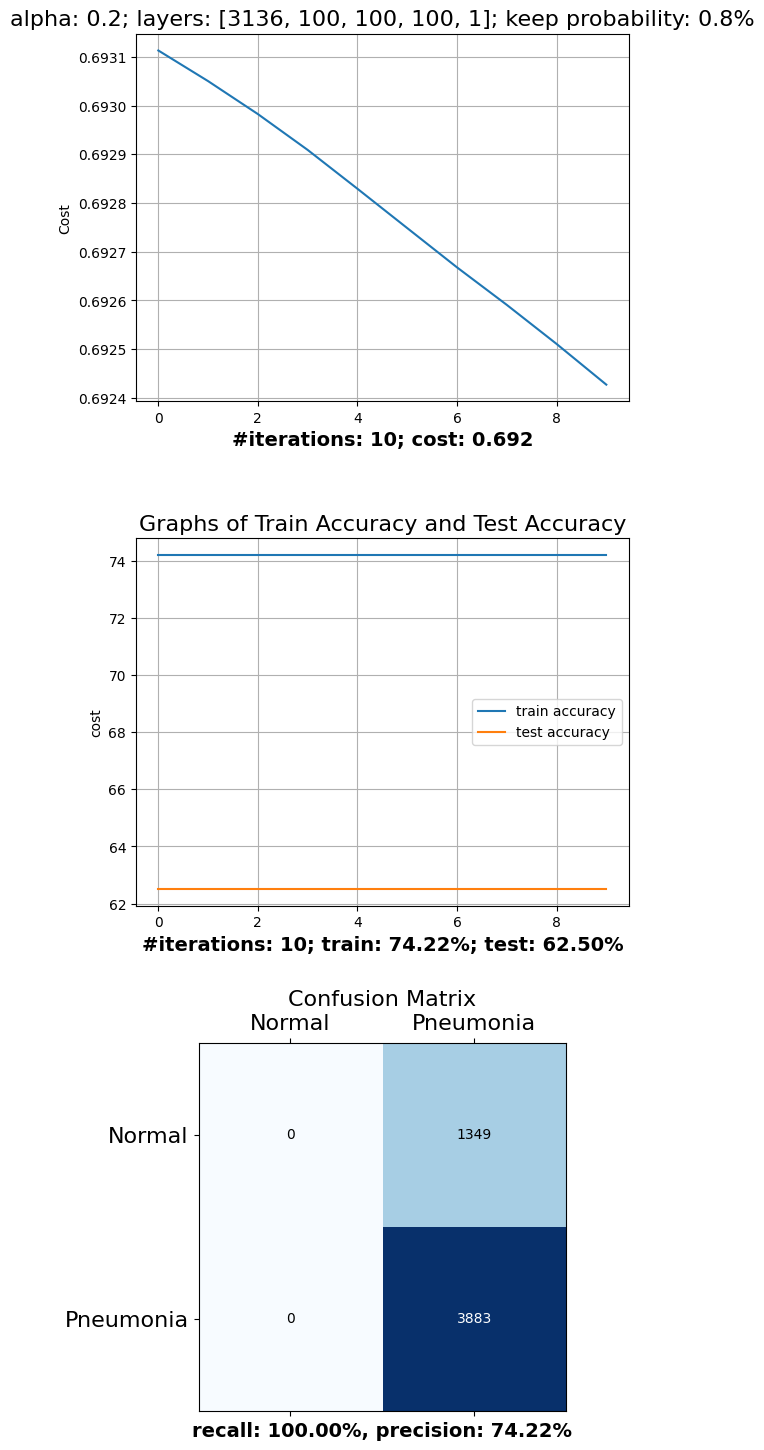

In [22]:
# Fonts
title_font = {'color':  'black', 'size': 16}
big_font =  {'color':  'black', 'size': 14, 'weight' : 'bold'}
white_font = {'color':  'white'}

fig = plt.figure()

# First suplot plotting the cost over time
ax1 = fig.add_subplot(311)
ax1.set_ylabel('Cost')
ax1.set_xlabel("#iterations: {}; cost: {:.3f}".format(str(number_of_iterations), costs[-1]), fontdict=big_font)
title_string = "alpha: {}; layers: {};".format(str(learning_rate), str(layer_dims))
if regularization:
    title_string = title_string + " lambda: {}".format(str(lambd))
if dropout:
    title_string = title_string + " keep probability: {}".format(str(keep_probability))
ax1.set_title(title_string, fontdict=title_font)
ax1.grid(True)
ax1.plot(costs)

# Second subplot plotting both the train accuracy and the test accuracy
if print_graph:
    ax2 = fig.add_subplot(312)
    ax2.set_ylabel('cost')
    ax2.set_xlabel('#iterations: {}; train: {:.2f}%; test: {:.2f}%'.format(str(number_of_iterations), train_accuracy_values[-1], test_accuracy_values[-1]), fontdict=big_font)
    ax2.set_title("Graphs of Train Accuracy and Test Accuracy", fontdict=title_font)
    ax2.grid(True)
    ax2.plot(train_accuracy_values, label='train accuracy')
    ax2.plot(test_accuracy_values, label='test accuracy')
    ax2.legend()

# Adjust for the height of the overall figure
fig.set_figheight(15)

# Plot the confusion matrix
ax3 = fig.add_subplot(313)
predictions = predict(parameters, train_X)
train_Y = train_Y.flatten()
predictions = predictions.flatten()
cm  = confusion_matrix(train_Y, predictions)

# Third subplot plotting the confusion model with the recall and precision value
ax3.set_title("Confusion Matrix", fontdict=title_font)
ax3.matshow(cm, cmap=plt.cm.Blues)
ax3.text(x=0, y=0, s=cm[0][0], va='center', ha='center')
ax3.text(x=1, y=0, s=cm[0][1], va='center', ha='center')
ax3.text(x=0, y=1, s=cm[1][0], va='center', ha='center')
ax3.text(x=1, y=1, s=cm[1][1], va='center', ha='center', fontdict=white_font)
ax3.set_xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
ax3.set_yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)

# Calculate recall and precision value
tn, fp, fn, tp = cm.ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
ax3.set_xlabel( "recall: {:.2f}%, precision: {:.2f}%".format(recall*100, precision*100), fontdict=big_font)

# Configure padding between the subplots
fig.tight_layout(pad=2.5)
plt.show()